In [3]:
import numpy as np
import cv2 
from PIL import Image
import os

In [4]:
dataset_path = "/home/ravil/assignment_mowito/data/anomaly_detection_test_data"
output_path = "/home/ravil/assignment_mowito/data/anomaly_detection_test_data/output"

### Verifying that every bad image has corresponding mask.

In [8]:
import cv2, pathlib, pandas as pd
root = pathlib.Path(dataset_path)
rows = []
for cls in ["good", "bad"]:
    for p in (root/cls).glob("*.png"):
        # print(p)
        img = cv2.imread(str(p))
        h,w,_ = img.shape
        rows.append({"file":p.name, "cls":cls, "h":h, "w":w})
df = pd.DataFrame(rows)
print(df.groupby("cls").agg({"file":"count","h":["min","max","median"],"w":["min","max","median"]}))

      file   h               w            
     count min  max median min  max median
cls                                       
bad   1023  78  336  183.0  80  331  277.0
good  4157  80  400  123.0  94  600  297.0


Observations

    All images are small-to-medium sized; nothing exceeds 600 px on either side.
    They are predominantly “wider than tall” (median width > median height).
    The bad-image resolution range is narrower; the biggest variability lies in the good set.

There is a huge dataset imbalance, almost 4:1. for every 4 good images we only have 1 bad image. For fixing this I will have to carefully choose metrics like f1-score instead of accuracy, loss function like weighted focal loss etc.

And for resizing I have two options:

Option 1 – square crop/pad

    Short side median ≈ 120 px; long side median ≈ 300 px.
    A 256×256 square is large enough to fit >90% of images with ≤2× up-scale on the smallest ones.
    Processing cost is low; compatible with ImageNet-pre-trained backbones.

Option 2 – keep aspect ratio with letter-boxing

    Resize the long side to 320 px, letter-box the short side to 320.
    Gives the model the same FoV across classes at the cost of black bars; store the resize factor for mask back-mapping.

I am currently moving with option 1 and will later try out letter-boxing


In [13]:
list_mask = []
list_orig = []
for i in ('masks', 'bad'):
    p = root / i
    for f in p.glob("*.png"):
        if i == 'masks':
            list_mask.append(f)
        else:
            list_orig.append(f)
assert len(list_mask) == len(list_orig)

Confirmed - Every image has corresponding mask to it

### drawing histogram of scratched area to see the total cover of scratched pixels in images

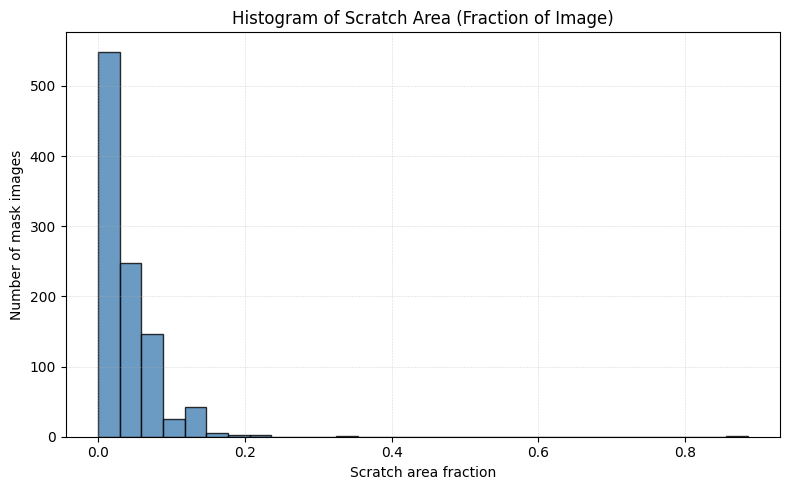

In [14]:
import pathlib
import numpy as np
import cv2           # pip install opencv-python-headless
import matplotlib.pyplot as plt

# 1.  Gather mask paths
MASK_DIR = pathlib.Path(f"{root}/masks")          # adjust if your folder is elsewhere
mask_paths = sorted(MASK_DIR.glob("*.png"))

scratch_fracs = []

# 2.  Compute scratch-pixel fraction for every mask
for mp in mask_paths:
    mask = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
    if mask is None:                   # skip corrupt or unreadable files
        continue
    scratch_frac = (mask > 128).sum() / mask.size   # white-pixel ratio
    scratch_fracs.append(scratch_frac)

# 3.  Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(scratch_fracs, bins=30, color="steelblue", alpha=0.8, edgecolor="black")
plt.title("Histogram of Scratch Area (Fraction of Image)")
plt.xlabel("Scratch area fraction")
plt.ylabel("Number of mask images")
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()

Results can be seen : - 

    Extreme skew toward tiny defects – Well over 90% of masks have a scratch-area fraction below 0.05 (≤5% of the image). Only a handful exceed 0.20, and just one or two are almost completely white.
     → Most scratches are thin streaks, not large blotches.

    Long “tail” of outliers – The isolated bars beyond 0.20 show a few masks whose white area is disproportionately large. They are probably annotation errors or badly binarised masks.

    Class granularity – Because the distribution is continuous but heavily bunched near zero, using a single fixed threshold (e.g., “bad if scratch > 1%”) may mis-classify many legitimate defects.

A segmentation or object-detection model that isolates individual streaks will work better than a pure image-level classifier, because it can learn pattern rather than “amount of white pixels”.
